In [36]:

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import warnings
warnings.filterwarnings("ignore")




In [37]:

df = pd.read_csv("/content/Fraud.csv")
print("Dataset Shape:", df.shape)

df = df.dropna(subset=['isFraud'])


Dataset Shape: (6362620, 11)


In [38]:

num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = num_cols.drop('isFraud')
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

In [39]:
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])


In [40]:

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [41]:
X_temp = df.drop("isFraud", axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(len(X_temp.columns))]
print(vif_data)

          feature        VIF
0            step   3.131677
1            type   5.344877
2          amount   3.011654
3        nameOrig   3.119554
4   oldbalanceOrg   6.190162
5  newbalanceOrig   7.222359
6        nameDest   4.199474
7  oldbalanceDest  34.213660
8  newbalanceDest  38.180189
9  isFlaggedFraud        NaN


In [42]:

X = df.drop("isFraud", axis=1)
y = df["isFraud"]

In [43]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [46]:

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 773.75


In [47]:

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': 10,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1
}

In [48]:


clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    learning_rate=0.05,
    num_leaves=64,
    max_depth=10,
    n_estimators=500,
    scale_pos_weight=scale_pos_weight
)

# Fit without early_stopping_rounds
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# Predict
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > 0.5).astype(int)


[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651247
[LightGBM] [Info] Start training from score -6.651247
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.953172	valid_0's binary_logloss: 1.21035
Early stopping, best iteration is:
[1]	valid_0's auc: 0.994998	valid_0's binary_logloss: 0.337517


In [49]:
# 🔟 Predict & Evaluate
y_pred_prob = clf.predict_proba(X_test)[:,1]  # probability of fraud
y_pred = (y_pred_prob > 0.5).astype(int)      # final class prediction


In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict probabilities and labels
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


Confusion Matrix:
[[1255761   15120]
 [     10    1633]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.10      0.99      0.18      1643

    accuracy                           0.99   1272524
   macro avg       0.55      0.99      0.59   1272524
weighted avg       1.00      0.99      0.99   1272524

ROC-AUC Score: 0.9949980615548024


In [51]:
joblib.dump(clf, "fraud_lightgbm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [52]:
print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!



Top Predictive Features (by importance):
          Feature  Importance
2          amount          16
4   oldbalanceOrg          15
0            step           8
1            type           6
8  newbalanceDest           5
3        nameOrig           4
5  newbalanceOrig           3
6        nameDest           3
7  oldbalanceDest           3
9  isFlaggedFraud           0


<Figure size 1000x600 with 0 Axes>

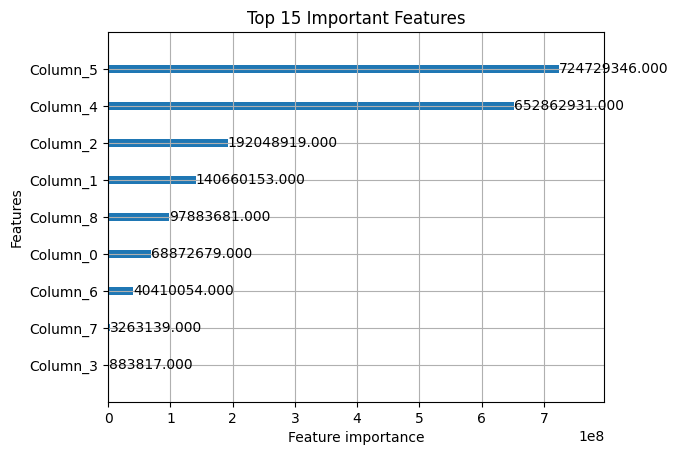

In [53]:
import matplotlib.pyplot as plt

# ----------------------------
# Feature Importance
# ----------------------------
print("\nTop Predictive Features (by importance):")
importance = clf.feature_importances_
feature_names = X.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importance})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

print(feat_imp.head(10))  # Show top 10 features

# Plot feature importance
plt.figure(figsize=(10,6))
lgb.plot_importance(clf, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features")
plt.show()


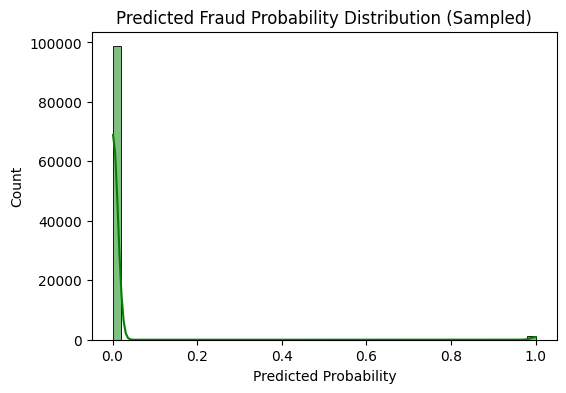

In [54]:
import numpy as np

sample_size = 100_000
actual_size = min(sample_size, len(y_pred_prob))  # choose the smaller

y_sample = y_pred_prob[np.random.choice(len(y_pred_prob), actual_size, replace=False)]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(y_sample, bins=50, kde=True, color='green')
plt.title("Predicted Fraud Probability Distribution (Sampled)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()


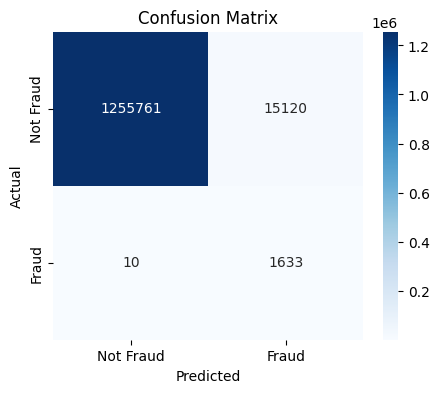

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud','Fraud'],
            yticklabels=['Not Fraud','Fraud'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

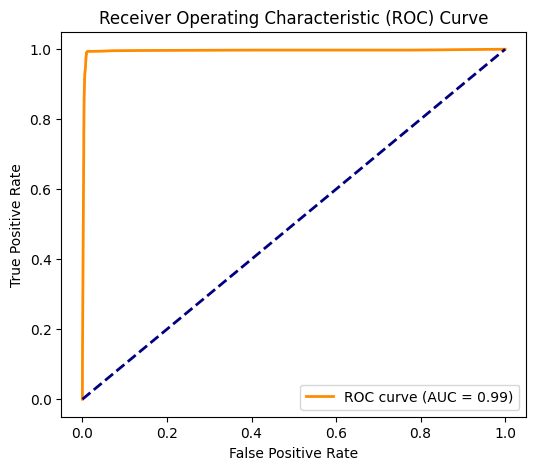

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [57]:

print("\n✅ Business Recommendations to Prevent Fraud:")
print("- Enable real-time alerts for unusually large transactions or new devices/locations.")
print("- Enforce multi-factor authentication for risky or high-value payments.")
print("- Apply adaptive transaction limits for new customers until they build a history.")
print("- Use velocity checks (many transactions in a short time → suspicious).")
print("- Continuously retrain the model on recent data to adapt to new fraud patterns.")


print("\n✅ How to Check if Actions Work:")
print("- Compare fraud rate before vs after interventions.")
print("- Track false positives (legit customers flagged incorrectly).")
print("- Monitor key metrics over time: Precision, Recall, ROC-AUC, PR-AUC.")
print("- Conduct A/B testing of fraud prevention policies.")
print("- Periodically run backtesting on historical data to validate improvements.")



✅ Business Recommendations to Prevent Fraud:
- Enable real-time alerts for unusually large transactions or new devices/locations.
- Enforce multi-factor authentication for risky or high-value payments.
- Apply adaptive transaction limits for new customers until they build a history.
- Use velocity checks (many transactions in a short time → suspicious).
- Continuously retrain the model on recent data to adapt to new fraud patterns.

✅ How to Check if Actions Work:
- Compare fraud rate before vs after interventions.
- Track false positives (legit customers flagged incorrectly).
- Monitor key metrics over time: Precision, Recall, ROC-AUC, PR-AUC.
- Conduct A/B testing of fraud prevention policies.
- Periodically run backtesting on historical data to validate improvements.
